In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pykeen
import torch

from pykeen.pipeline import pipeline

In [14]:
dataset = 'WN18RR'
num_epochs = 1000
embedding_dim = 20
loss = 'BCEWithLogitsLoss'
alpha = 0.01
margin = 3.0

In [15]:
ds = pykeen.datasets.get_dataset(dataset=dataset)

training = ds.training.mapped_triples
ds.training.mapped_triples = training[training[:,0].sort()[1]]
testing = ds.testing.mapped_triples
ds.testing.mapped_triples = testing[testing[:,0].sort()[1]]
validation = ds.validation.mapped_triples
ds.validation.mapped_triples = validation[validation[:,0].sort()[1]]

In [16]:
import functools
import itertools
from typing import Optional

from pykeen.models import StructuredEmbedding
from pykeen.models.base import EntityEmbeddingModel
from pykeen.nn import Embedding
from pykeen.losses import Loss
from pykeen.nn.init import xavier_uniform_
from pykeen.regularizers import Regularizer
from pykeen.triples import TriplesFactory
from pykeen.typing import DeviceHint
from pykeen.utils import compose

from torch.nn import functional
from torch import nn

import geotorch

class ModifiedSE(StructuredEmbedding):
    
    def __init__(
        self,
        triples_factory: TriplesFactory,
        embedding_dim: int = 20,
        alpha: float = 0.1,
        scoring_fct_norm: int = 2,
        loss: Optional[Loss] = None,
        preferred_device: DeviceHint = None,
        random_seed: Optional[int] = None,
        regularizer: Optional[Regularizer] = None,
    ) -> None:
        r"""Initialize SE.

        :param embedding_dim: The entity embedding dimension $d$. Is usually $d \in [50, 300]$.
        :param scoring_fct_norm: The $l_p$ norm. Usually 1 for SE.
        """
        super().__init__(
            triples_factory=triples_factory,
            embedding_dim=embedding_dim,
            loss=loss,
            preferred_device=preferred_device,
            random_seed=random_seed,
            regularizer=regularizer,
        )
        
        self.alpha = alpha
        
        # Embeddings
        init_bound = 6 / np.sqrt(self.embedding_dim)
        
        tsize = (triples_factory.num_relations, embedding_dim, embedding_dim)
        l = np.random.uniform(low=-init_bound, high=init_bound, size=tsize)
        r = np.random.uniform(low=-init_bound, high=init_bound, size=tsize)
        
        self.I = torch.eye(embedding_dim, device=preferred_device)
        
        self.left_embeddings = nn.init.orthogonal_(torch.tensor(l, device=preferred_device, requires_grad=True, dtype=torch.float32))
        self.right_embeddings = nn.init.orthogonal_(torch.tensor(r, device=preferred_device, requires_grad=True, dtype=torch.float32))
        
        
    def score_hrt(self, hrt_batch: torch.LongTensor) -> torch.FloatTensor:  # noqa: D102
        # Get embeddings
        h = self.entity_embeddings(indices=hrt_batch[:, 0]).view(-1, self.embedding_dim, 1)
        rel_h = torch.index_select(self.left_embeddings, 0, hrt_batch[:, 1])
        rel_t = torch.index_select(self.right_embeddings, 0, hrt_batch[:, 1])
        t = self.entity_embeddings(indices=hrt_batch[:, 2]).view(-1, self.embedding_dim, 1)

        # Project entities
        proj_h = rel_h @ h
        proj_t = rel_t @ t
        
        right_orth_penalty = torch.norm(rel_t @ torch.transpose(rel_t, 1,2) - self.I[None,:,:])
        left_orth_penalty = torch.norm(rel_h @ torch.transpose(rel_h, 1,2) - self.I[None,:,:])

        scores = -torch.norm(proj_h - proj_t, dim=1, p=self.scoring_fct_norm) - self.alpha*(right_orth_penalty + left_orth_penalty)
        return scores


    def score_t(self, hr_batch: torch.LongTensor, slice_size: int = None) -> torch.FloatTensor:  # noqa: D102
        # Get embeddings
        h = self.entity_embeddings(indices=hr_batch[:, 0]).view(-1, self.embedding_dim, 1)
        rel_h = torch.index_select(self.left_embeddings, 0, hr_batch[:, 1])
        rel_t = torch.index_select(self.right_embeddings, 0, hr_batch[:, 1])
        rel_t = rel_t.view(-1, 1, self.embedding_dim, self.embedding_dim)
        t_all = self.entity_embeddings(indices=None).view(1, -1, self.embedding_dim, 1)

        if slice_size is not None:
            proj_t_arr = []
            # Project entities
            proj_h = rel_h @ h

            for t in torch.split(t_all, slice_size, dim=1):
                # Project entities
                proj_t = rel_t @ t
                proj_t_arr.append(proj_t)

            proj_t = torch.cat(proj_t_arr, dim=1)

        else:
            # Project entities
            proj_h = rel_h @ h
            proj_t = rel_t @ t_all

        scores = -torch.norm(proj_h[:, None, :, 0] - proj_t[:, :, :, 0], dim=-1, p=self.scoring_fct_norm)

        return scores


    def score_h(self, rt_batch: torch.LongTensor, slice_size: int = None) -> torch.FloatTensor:  # noqa: D102
        # Get embeddings
        h_all = self.entity_embeddings(indices=None).view(1, -1, self.embedding_dim, 1)
        rel_h = torch.index_select(self.left_embeddings, 0, rt_batch[:, 0])
        rel_h = rel_h.view(-1, 1, self.embedding_dim, self.embedding_dim)
        rel_t = torch.index_select(self.right_embeddings, 0, rt_batch[:, 0])
        t = self.entity_embeddings(indices=rt_batch[:, 1]).view(-1, self.embedding_dim, 1)

        if slice_size is not None:
            proj_h_arr = []

            # Project entities
            proj_t = rel_t @ t

            for h in torch.split(h_all, slice_size, dim=1):
                # Project entities
                proj_h = rel_h @ h
                proj_h_arr.append(proj_h)

            proj_h = torch.cat(proj_h_arr, dim=1)
        else:
            # Project entities
            proj_h = rel_h @ h_all
            proj_t = rel_t @ t

        scores = -torch.norm(proj_h[:, :, :, 0] - proj_t[:, None, :, 0], dim=-1, p=self.scoring_fct_norm)

        return scores

In [17]:
result2 = pipeline(
    model=ModifiedSE,
    dataset=dataset,
    random_seed=1235,
    device='gpu',
    training_kwargs=dict(num_epochs=num_epochs, sampler='presorted'),
    evaluation_kwargs=dict(),
    model_kwargs=dict(embedding_dim=embedding_dim, alpha=alpha),
    loss=loss,
    loss_kwargs=dict()
)
model2 = result2.model
model2

Not Shuffling!


INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...


INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=64.


INFO:pykeen.evaluation.evaluator:Evaluation took 10.32s seconds


ModifiedSE(
  (loss): BCEWithLogitsLoss()
  (regularizer): NoRegularizer()
  (entity_embeddings): Embedding(
    (_embeddings): Embedding(40559, 20)
  )
  (left_relation_embeddings): Embedding(
    (_embeddings): Embedding(11, 400)
  )
  (right_relation_embeddings): Embedding(
    (_embeddings): Embedding(11, 400)
  )
)

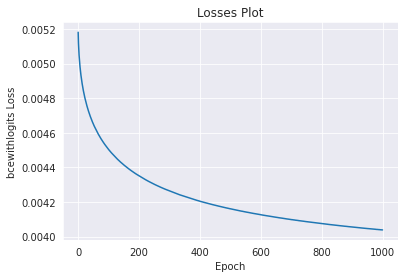

In [18]:
result2.plot_losses()
plt.show()

In [7]:
comp_models = ['StructuredEmbedding','TransE','RotatE','HolE']
comp_results = []
for comp_model in comp_models:
    print('Running {}'.format(comp_model))
    result = pipeline(
        dataset=dataset,
        model=comp_model,
        random_seed=1235,
        device='gpu',
        training_kwargs=dict(num_epochs=num_epochs),
        model_kwargs=dict(embedding_dim=embedding_dim),
        loss=loss,
        loss_kwargs=dict()
    )
    comp_results.append(result)

Running StructuredEmbedding


INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...


INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=64.


INFO:pykeen.evaluation.evaluator:Evaluation took 10.32s seconds



Running TransE


INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...


INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=512.


INFO:pykeen.evaluation.evaluator:Evaluation took 0.77s seconds



Running RotatE


INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...


INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=512.


INFO:pykeen.evaluation.evaluator:Evaluation took 1.12s seconds



Running HolE


/home/gebhart/projects/pykeen/src/pykeen/models/unimodal/hole.py:102: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  a_fft = torch.rfft(h, signal_ndim=1, onesided=True)
/home/gebhart/projects/pykeen/src/pykeen/models/unimodal/hole.py:112: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  composite = torch.irfft(p_fft, signal_ndim=1, onesided=True, signal_sizes=(h.shape[-1],))


INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...


INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=128.


INFO:pykeen.evaluation.evaluator:Evaluation took 1.58s seconds


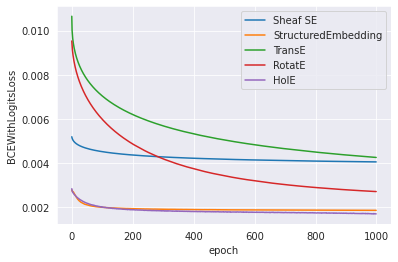

In [19]:
plt.plot(np.arange(len(result2.losses)),result2.losses,label='Sheaf SE')
for i in range(len(comp_models)):
    comp_model = comp_models[i]
    comp_result = comp_results[i]
    plt.plot(np.arange(len(comp_result.losses)),comp_result.losses,label=comp_model)
plt.ylabel(str(result.model.loss).replace('()',''))
plt.xlabel('epoch')
plt.legend()
plt.show()

In [20]:
res_df = result2.metric_results.to_df()

In [31]:
compto = 1

In [32]:
res_df['diff'] = res_df.Value - comp_results[compto].metric_results.to_df().Value
res_df

,Side,Type,Metric,Value,diff
0,both,avg,adjusted_mean_rank,0.781027,0.449552
1,tail,avg,adjusted_mean_rank,0.603155,0.288131
2,head,avg,adjusted_mean_rank,0.958899,0.610972
3,both,best,mean_rank,15830.751368,9111.673393
4,both,best,mean_reciprocal_rank,0.004617,-0.104179
5,both,best,hits_at_1,0.002394,-0.000171
6,both,best,hits_at_3,0.003933,-0.182285
7,both,best,hits_at_5,0.005301,-0.236491
8,both,best,hits_at_10,0.007353,-0.287449
9,both,worst,mean_rank,15830.756498,9111.673906


In [12]:
# comp_results[0].model.score_all_triples()

In [13]:
# model2.score_all_triples()